In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
def fetch_stock_data(ticker, start_date):
    # Get the current date to set as the end date
    end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
    # Download stock price data from yfinance for the given date range
    stock_data = yf.download(ticker, start=start_date, end="2009-12-31")  # Fetch data during the pandemic period

    return stock_data


def detect_black_swan_events(data, z_threshold=-3, percentile_threshold=0.3, window=20, deviation_threshold=-3):
    # Calculate daily returns (percentage change in 'Close' prices)
    data['Daily Return'] = data['Close'].pct_change().fillna(0)

    ### Method 1: Z-score based on daily returns
    # Calculate Z-scores for daily returns
    data['Z-Score'] = zscore(data['Daily Return'])
    # Flag black swan events where the Z-score is below the specified threshold
    data['BlackSwan_ZScore'] = np.where(data['Z-Score'] < z_threshold, 1, 0)


    ### Method 2: Percentile-based threshold on daily returns (Absolute Reuturn)
    # Determine the cutoff value for the specified lower percentile of daily returns
    percentile_value = np.percentile(data['Daily Return'], percentile_threshold)
    # Flag black swan events where the daily return falls below the percentile threshold
    data['BlackSwan_Percentile'] = np.where(data['Daily Return'] < percentile_value, 1, 0)


    ### Method 3: Price deviation from rolling mean
    # Calculate rolling mean and rolling standard deviation over the specified window
    data['Rolling Mean'] = data['Close'].rolling(window=window).mean()
    data['Rolling Std'] = data['Close'].rolling(window=window).std()
    # Measure the deviation of the current price from the rolling mean, in terms of standard deviations
    data['Price Deviation'] = (data['Close'] - data['Rolling Mean']) / data['Rolling Std']
    # Flag black swan events where the price deviation exceeds the threshold
    data['BlackSwan_Deviation'] = np.where(data['Price Deviation'].fillna(0) < deviation_threshold, 1, 0)

    
    # Filter the data to include only rows where at least one method detected a black swan event
    black_swan_events = data.loc[
        (data['BlackSwan_ZScore'] == 1) | 
        (data['BlackSwan_Deviation'] == 1) | 
        (data['BlackSwan_Percentile'] == 1)
    ]
    # Print a summary of detected events for each method
    print(f"Detected black swan events (Z-Score: {len(data[data['BlackSwan_ZScore'] == 1])}, "
          f"Price Deviation: {len(data[data['BlackSwan_Deviation'] == 1])}, "
          f"Percentile: {len(data[data['BlackSwan_Percentile'] == 1])}, ")
    
    return data, black_swan_events


def plot_black_swan_events(ticker, data):
    # Create a figure with 4 subplots, each representing a different method of black swan detection
    fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

    # Method 1: Z-score black swan events
    axes[0].plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.5)
    axes[0].scatter(data.index[data['BlackSwan_ZScore'] == 1], data['Close'][data['BlackSwan_ZScore'] == 1], 
                    color='red', marker='o', label='Black Swan (Z-Score)', s=100)
    axes[0].set_title(f'{ticker} - Black Swan Events (Z-Score Method)')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)

    # Method 2: Percentile black swan events
    axes[1].plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.5)
    axes[1].scatter(data.index[data['BlackSwan_Percentile'] == 1], data['Close'][data['BlackSwan_Percentile'] == 1], 
                    color='purple', marker='o', label='Black Swan (Percentile)', s=100)
    axes[1].set_title(f'{ticker} - Black Swan Events (Percentile Method)')
    axes[1].set_ylabel('Price')
    axes[1].legend()
    axes[1].grid(True)

    # Method 3: Price deviation to moving average
    axes[2].plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.5)
    axes[2].scatter(data.index[data['BlackSwan_Deviation'] == 1], data['Close'][data['BlackSwan_Deviation'] == 1], 
                    color='green', marker='o', label='Black Swan (Price Deviation)', s=100)
    axes[2].set_title(f'{ticker} - Black Swan Events (Price Deviation Method)')
    axes[2].set_ylabel('Price')
    axes[2].legend()
    axes[2].grid(True)

    # Adjust layout for better spacing between subplots
    plt.tight_layout()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


Detected black swan events (Z-Score: 41, Price Deviation: 90, Percentile: 53, 


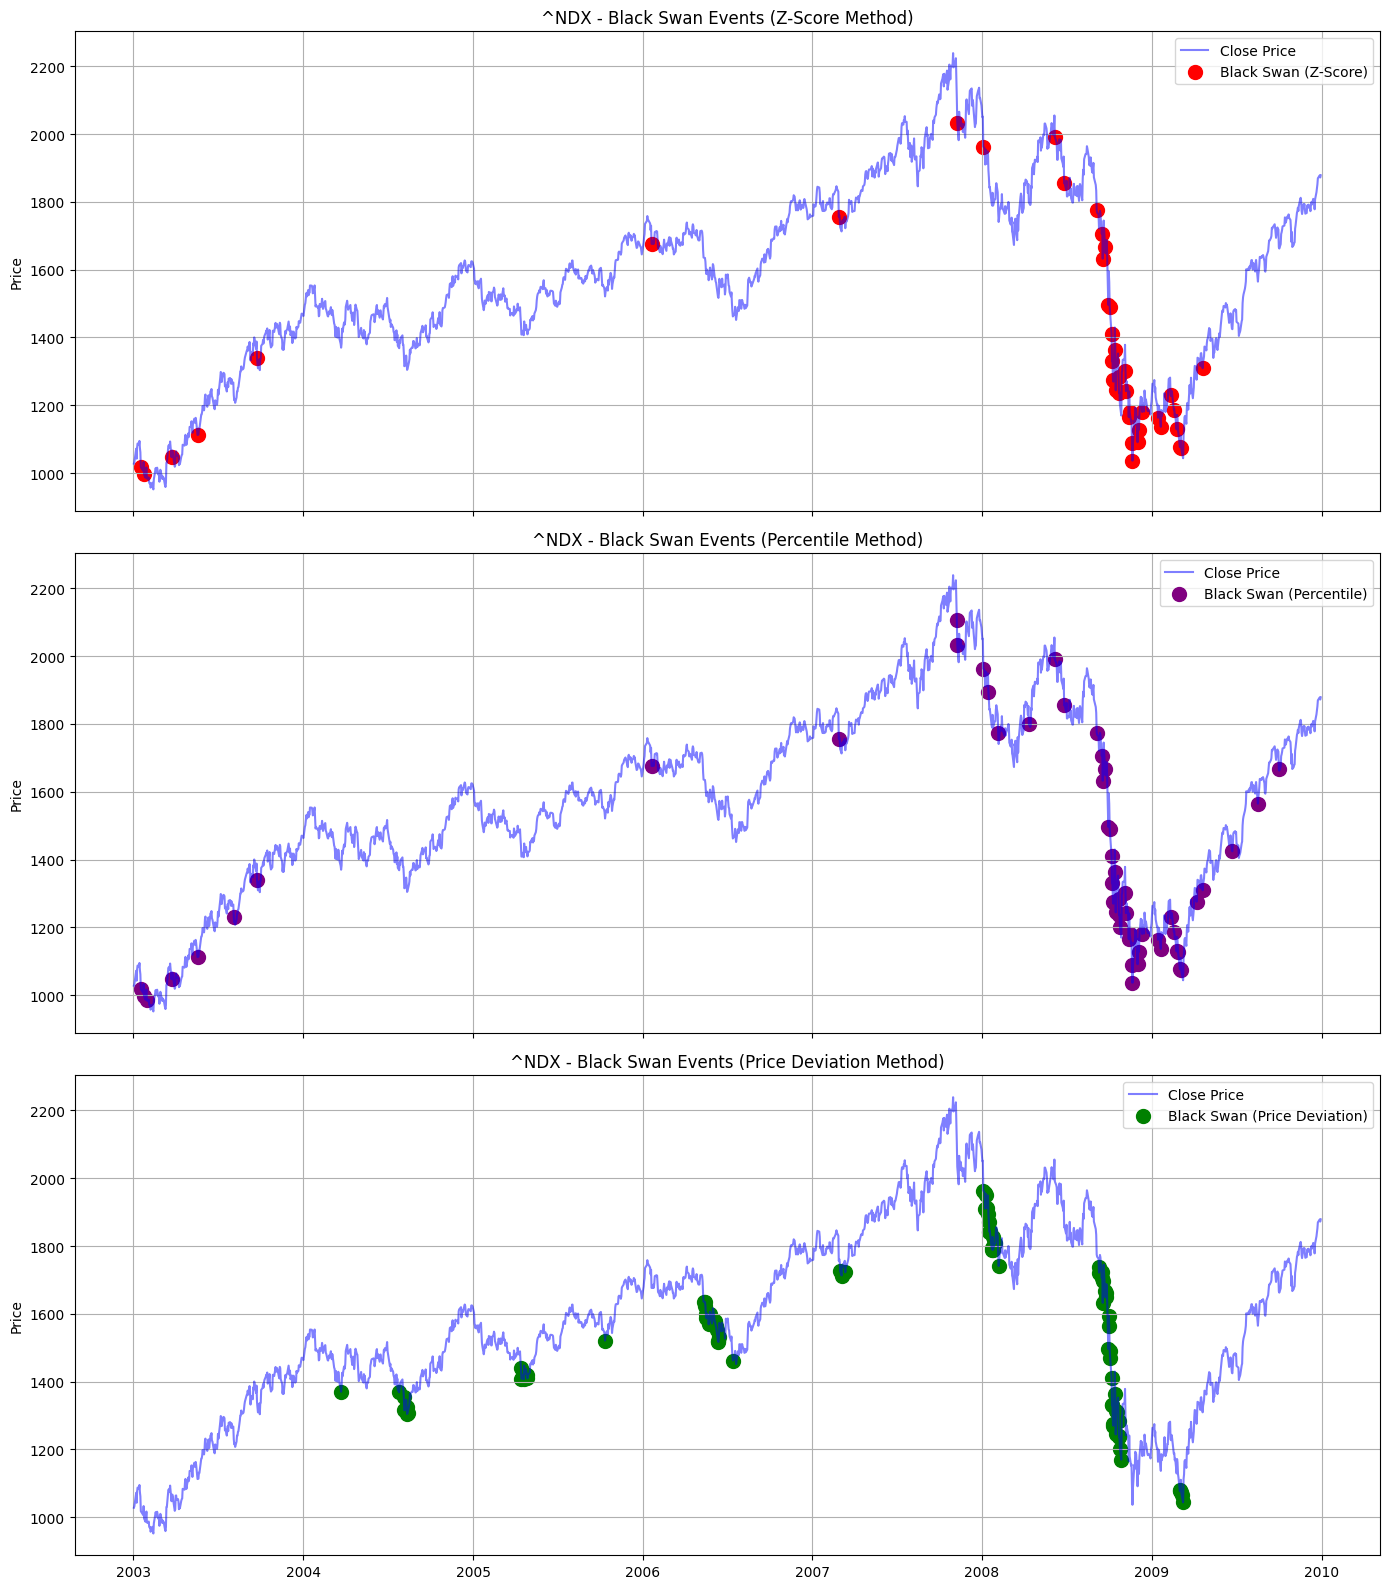

In [3]:
# Example usage
ticker = '^NDX'                 # Index better subjects to detect worldwide drops
start_date = '2003-01-01'

# Fetch index data
stock_data = fetch_stock_data(ticker, start_date)

# Detect black swan events using all methods
stock_data, black_swan_events = detect_black_swan_events(stock_data, 
                                                         z_threshold=-2, 
                                                         percentile_threshold=3,
                                                         window=70,
                                                         deviation_threshold=-2)

# Plot black swan events separately for each method
plot_black_swan_events(ticker, stock_data)

A good idea might be to register when multiple signals are lit within a short period. Perhaps validate through cross methods as well. The signals always lag behind however.